In [4]:
using Distributed
addprocs(5);

In [5]:
@everywhere using DrWatson
@everywhere @quickactivate "Qwind"
using Qwind
include("../../scripts/plotting.jl")

      From worker 4:	  Activating environment at `~/code/Qwind.jl/Project.toml`
      From worker 6:	  Activating environment at `~/code/Qwind.jl/Project.toml`
      From worker 3:	  Activating environment at `~/code/Qwind.jl/Project.toml`
      From worker 5:	  Activating environment at `~/code/Qwind.jl/Project.toml`
      From worker 2:	  Activating environment at `~/code/Qwind.jl/Project.toml`


┌ Info: Precompiling Qwind [988db7c6-b368-4d8d-9ee1-ae26d5771fb3]
└ @ Base loading.jl:1313


Main.QwindPlotting

In [6]:
model = Model("./config.yaml");
#try
#    rm(model.config[:integrator][:save_path], recursive=true)
#catch
#end
#iterations_dict = Dict();
#run!(model, iterations_dict);

In [7]:
using JLD2
@load "iterations_dict.jld2" iterations_dict

┌ Warning: 2021-03-19 09:10:01 type Qwind.#func!#58{RegularGrid{Float64},typeof(Qwind.residual!)} does not exist in workspace; reconstructing
└ @ JLD2 ~/.julia/packages/JLD2/pA6G3/src/data/reconstructing_datatypes.jl:450
┌ Warning: 2021-03-19 09:10:02 some parameters could not be resolved for type DiffEqBase.DiscreteCallback{typeof(Qwind.termination_condition),Qwind.#51#53,typeof(DiffEqBase.INITIALIZE_DEFAULT),typeof(DiffEqBase.FINALIZE_DEFAULT)}; reconstructing
└ @ JLD2 ~/.julia/packages/JLD2/pA6G3/src/data/reconstructing_datatypes.jl:440
┌ Warning: 2021-03-19 09:10:02 type Qwind.#52#54{Int64,RegularGrid{Float64}} does not exist in workspace; reconstructing
└ @ JLD2 ~/.julia/packages/JLD2/pA6G3/src/data/reconstructing_datatypes.jl:450


1-element Vector{Symbol}:
 :iterations_dict

In [8]:
iterations_dict

Dict{Any, Any} with 6 entries:
  5 => Dict{Any, Any}("radiative_transfer"=>RegularGrid{Float64}(QsosedRadiatio…
  4 => Dict{Any, Any}("radiative_transfer"=>RegularGrid{Float64}(QsosedRadiatio…
  6 => Dict{Any, Any}("radiative_transfer"=>RegularGrid{Float64}(QsosedRadiatio…
  2 => Dict{Any, Any}("radiative_transfer"=>RegularGrid{Float64}(QsosedRadiatio…
  3 => Dict{Any, Any}("radiative_transfer"=>RegularGrid{Float64}(QsosedRadiatio…
  1 => Dict{Any, Any}("radiative_transfer"=>RegularGrid{Float64}(QsosedRadiatio…

In [42]:
using PyPlot, ColorSchemes, Colors, PyCall
include("../../scripts/plotting.jl")
include("./style.jl")
dpi=350
cmap = colorschemes[:matter]
cmap_pl = ColorMap("cmap", cmap.colors)
Normalize = matplotlib.colors.Normalize
rcParams = PyDict(matplotlib["rcParams"])
rcParams["figure.dpi"] = 250

250

# Reduce integrators

In [86]:
integrators = iterations_dict[5]["integrators"];

In [87]:
max_times = get_intersection_times(integrators);

┌ Info: Calculating trajectory intersections...
└ @ Qwind /home/arnau/code/Qwind.jl/src/intersections.jl:150
Progress: 100%|█████████████████████████████████████████| Time: 0:00:43


In [88]:
integrators_interpolated = interpolate_integrators(integrators, max_times=max_times);

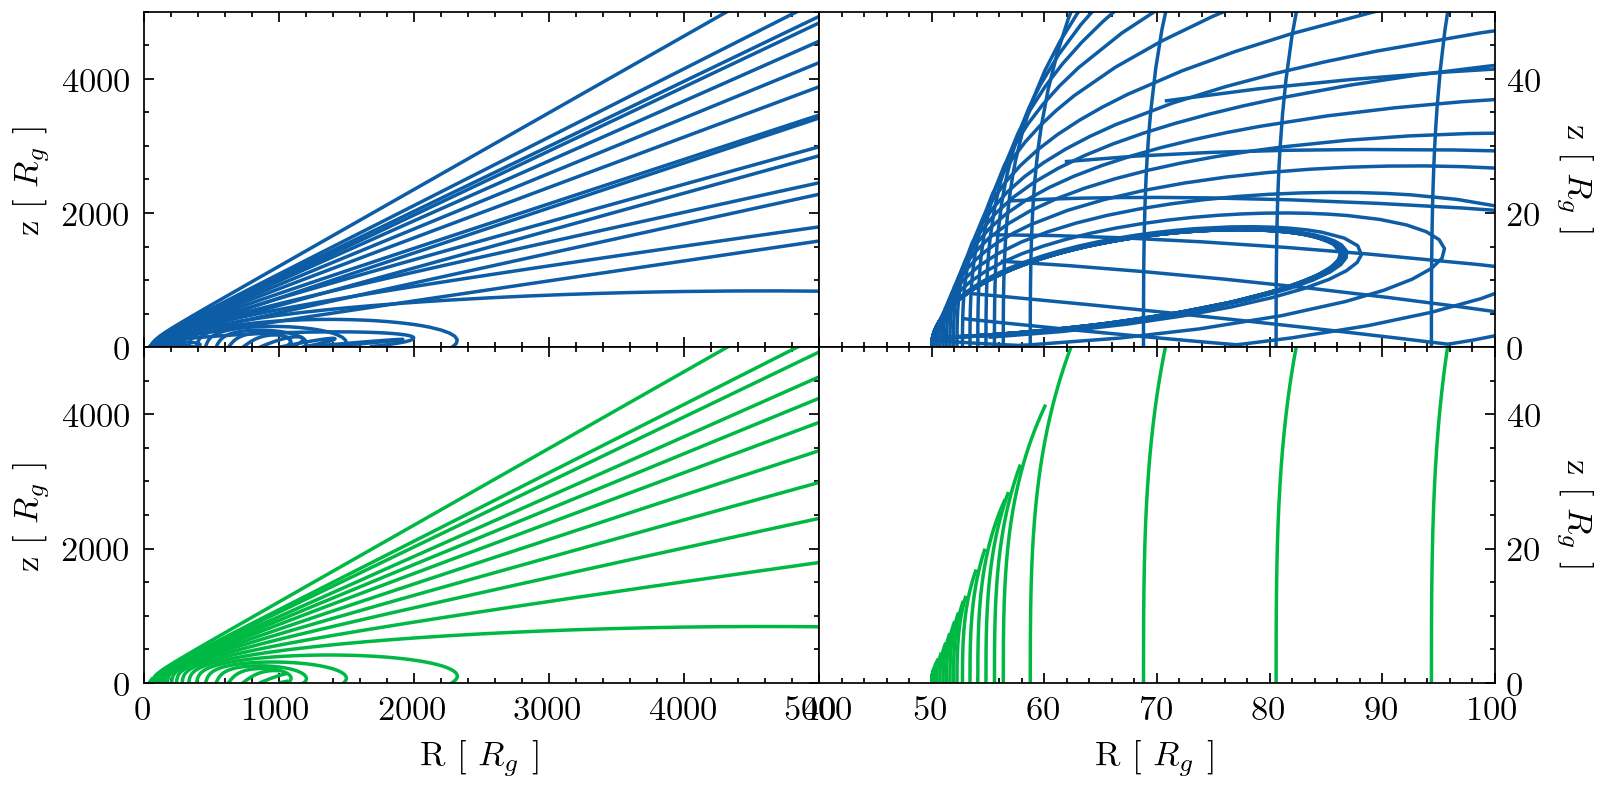

In [90]:
fig, ax = plt.subplots(2, 2, figsize=(2 * mnras_width, mnras_width))
for (integ, integ_reduced) in zip(integrators[1:5:end], integrators_interpolated[1:5:end])
    ax[1,1].plot(integ.p.data[:r], integ.p.data[:z], color = "C0")
    ax[2,1].plot(integ_reduced.r, integ_reduced.z, color = "C1")
    
    ax[1,2].plot(integ.p.data[:r], integ.p.data[:z], color = "C0")
    ax[2,2].plot(integ_reduced.r, integ_reduced.z, color = "C1")
end

ax[1,1].set_xlim(0,5000)
ax[2,1].set_xlim(0,5000)

ax[1,1].set_ylim(0,5000)
ax[2,1].set_ylim(0,5000)

ax[1,2].set_xlim(40, 100)
ax[2,2].set_xlim(40, 100)
ax[1,2].set_ylim(0,50)
ax[2,2].set_ylim(0,50)

ax[1,1].set_ylabel(L"z [ $R_g$ ]")
ax[2,1].set_ylabel(L"z [ $R_g$ ]")
ax[2,1].set_xlabel(L"R [ $R_g$ ]")
ax[2,2].set_xlabel(L"R [ $R_g$ ]")

ax[1,2].set_ylabel(L"z [ $R_g$ ]", rotation=-90, labelpad=15)
ax[2,2].set_ylabel(L"z [ $R_g$ ]", rotation=-90, labelpad=15)
ax[1,2].yaxis.set_label_position("right")
ax[2,2].yaxis.set_label_position("right")


ax[1,2].yaxis.tick_right()
ax[2,2].yaxis.tick_right()

ax[1,1].set_xticklabels([])
ax[1,2].set_xticklabels([])

plt.subplots_adjust(wspace=0, hspace=0)


In [91]:
function get_density_grid(r, z, n, r0, hull; rmin=1, rmax=1000, zmin=1e-6, zmax=1000, interpolation_type="nn", nr=250, nz=250)
    interpolator = Qwind.get_density_interpolator(r, z, n, type=interpolation_type)
    r_range = collect(range(rmin, rmax, length=nr))
    z_range = collect(range(zmin, zmax, length=nz))
    r_range_log = log10.(r_range)
    z_range_log = log10.(z_range)
    density_grid = 1e2 .* ones((length(r_range), length(z_range)))
    for (i, r) in enumerate(r_range)
        for (j, z) in enumerate(z_range)
            point = [r, z]
            if !Qwind.is_point_in_wind(hull, point)
                density_grid[i, j] = 1e2
            else
                density_grid[i, j] = 10 .^ interpolator(log10(r), log10(z))[1]
            end
        end
    end
    # add z = 0 line
    density_grid = [density_grid[:, 1] density_grid]
    pushfirst!(z_range, 0.0)
    grid = DensityGrid(r_range, z_range, density_grid, nr, nz)
    return grid
end

function get_velocity_grid(r, z, vr, vz, r0, hull; rmin=1, rmax=1000, zmin=1e-6, zmax=1000, interpolation_type="nn", nr=250, nz=250)
    vr_interp, vz_interp = Qwind.get_velocity_interpolators(r, z, vr, vz, type=interpolation_type)
    r_range = collect(range(rmin, rmax, length=nr))
    z_range = collect(range(zmin, zmax, length=nz))
    r_range_log = log10.(r_range)
    z_range_log = log10.(z_range)
    vr_grid = zeros((length(r_range), length(z_range)))
    vz_grid = zeros((length(r_range), length(z_range)))
    for (i, r) in enumerate(r_range)
        for (j, z) in enumerate(z_range)
            point = [r, z]
            if !Qwind.is_point_in_wind(hull, point)
                continue
            else
                vr_grid[i,j] = vr_interp(log10(r), log10(z))[1]
                vz_grid[i,j] = vz_interp(log10(r), log10(z))[1]
            end
        end
    end
    # add z = 0 line
    vr_grid = [vr_grid[:,1] vr_grid]
    vz_grid = [vz_grid[:,1] vz_grid]
    pushfirst!(z_range, 0.0)
    grid = VelocityGrid(r_range, z_range, vr_grid, vz_grid, nr, nz)
    @info "Done"
    return grid

end


get_velocity_grid (generic function with 1 method)

In [92]:
r0 = [integ.p.r0 for integ in integrators];
rh, zh, _, _, _ = reduce_integrators(integrators, max_times=max_times)
hull = construct_wind_hull(rh, zh, r0);

┌ Info: Constructing wind hull...
└ @ Qwind /home/arnau/code/Qwind.jl/src/radiative_transfer/wind_interpolator/wind_hull.jl:34
┌ Info: Done
└ @ Qwind /home/arnau/code/Qwind.jl/src/radiative_transfer/wind_interpolator/wind_hull.jl:40


In [93]:
r, z, vr, vz, n = reduce_integrators(integrators_interpolated);

In [94]:
density_grid_nn = get_density_grid(r, z, n, r0, hull, rmin=50, rmax=52, zmin=1, zmax=5, nz=500, nr=500, interpolation_type="nn");
density_grid_linear = get_density_grid(r, z, n, r0, hull, rmin=50, rmax=52, zmin=1, zmax=5, nz=500, nr=500, interpolation_type="linear");

In [97]:
velocity_grid_nn = get_velocity_grid(r, z, vr, vz, r0, hull, rmin=50, rmax=60, zmin=1, zmax=20, interpolation_type="nn");
velocity_grid_linear = get_velocity_grid(r, z, vr, vz, r0, hull, rmin=50, rmax=60, zmin=1, zmax=20, interpolation_type="linear");

┌ Info: Done
└ @ Main In[91]:49
┌ Info: Done
└ @ Main In[91]:49


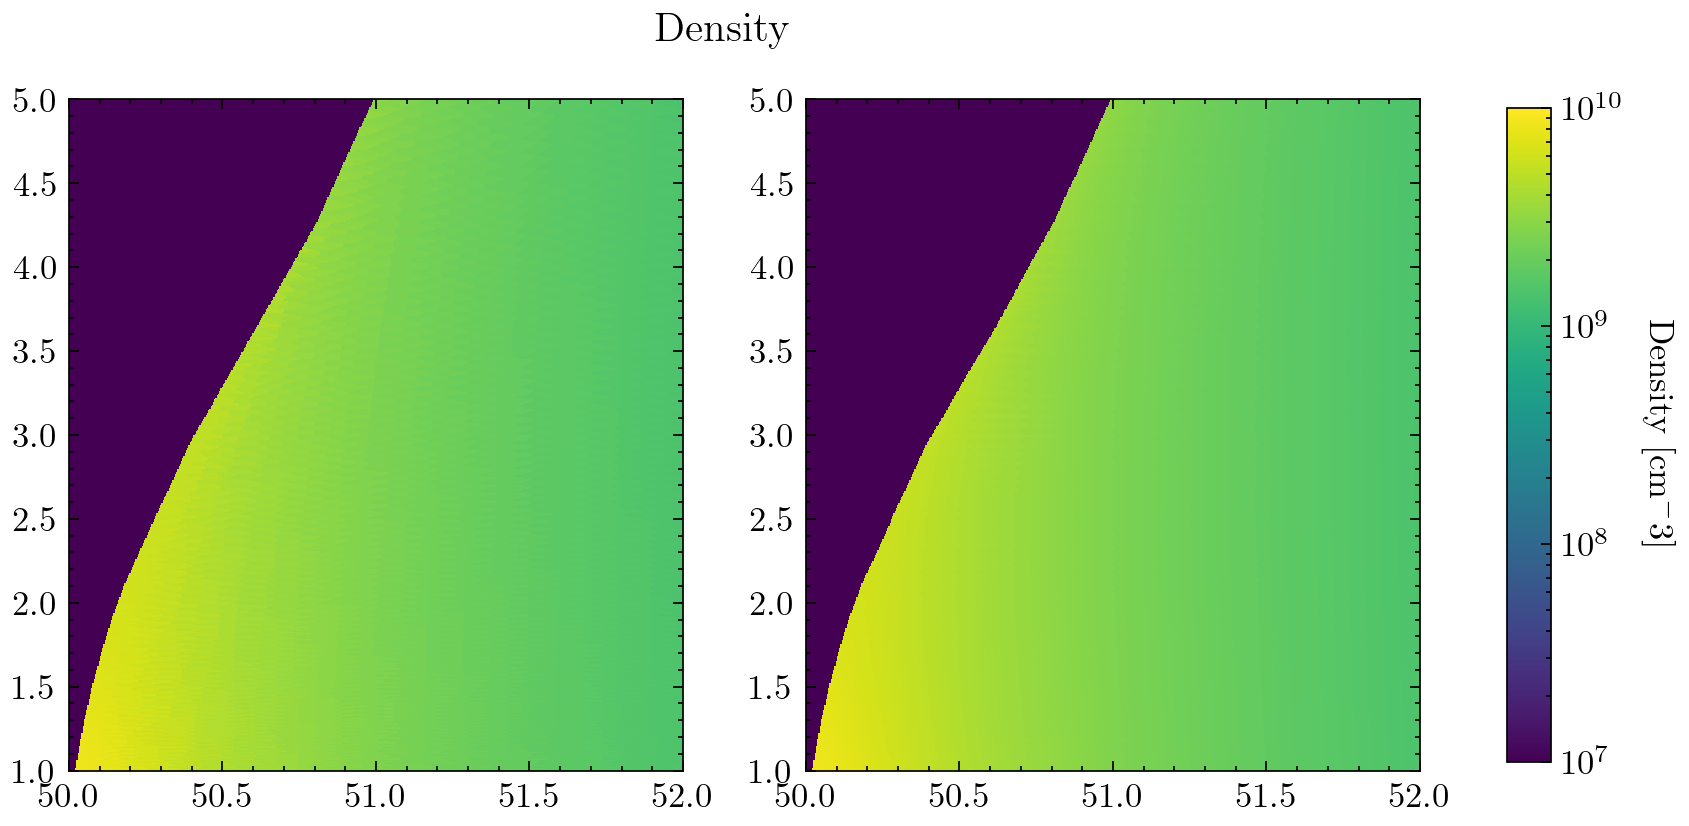

PyObject Text(0.5, 0.98, 'Density')

In [95]:
fig, ax = plt.subplots(1, 2, figsize=(2*mnras_width, mnras_width))
cm = ax[1].pcolormesh(density_grid_nn.r_range, density_grid_nn.z_range, density_grid_nn.grid', norm=LogNorm(vmin=1e7, vmax=1e10), shading="auto")
cm = ax[2].pcolormesh(density_grid_linear.r_range, density_grid_linear.z_range, density_grid_linear.grid', norm=LogNorm(vmin=1e7, vmax=1e10), shading="auto")

for integ_reduced in integrators_reduced
    #ax[1].plot(integ_reduced.r, integ_reduced.z, color = "black", alpha=0.5)
    #ax[2].plot(integ_reduced.r, integ_reduced.z, color = "black", alpha=0.5)
end

cbar_ax = fig.add_axes([0.95, 0.12, 0.025, 0.75])
cbar = fig.colorbar(cm, cax=cbar_ax)
cbar.set_label(L"Density [cm$^-3$]", rotation=-90, labelpad=15)

for axis in ax
    axis.set_xlim(50, 52)
    axis.set_ylim(1, 5)
end
fig.suptitle("Density")

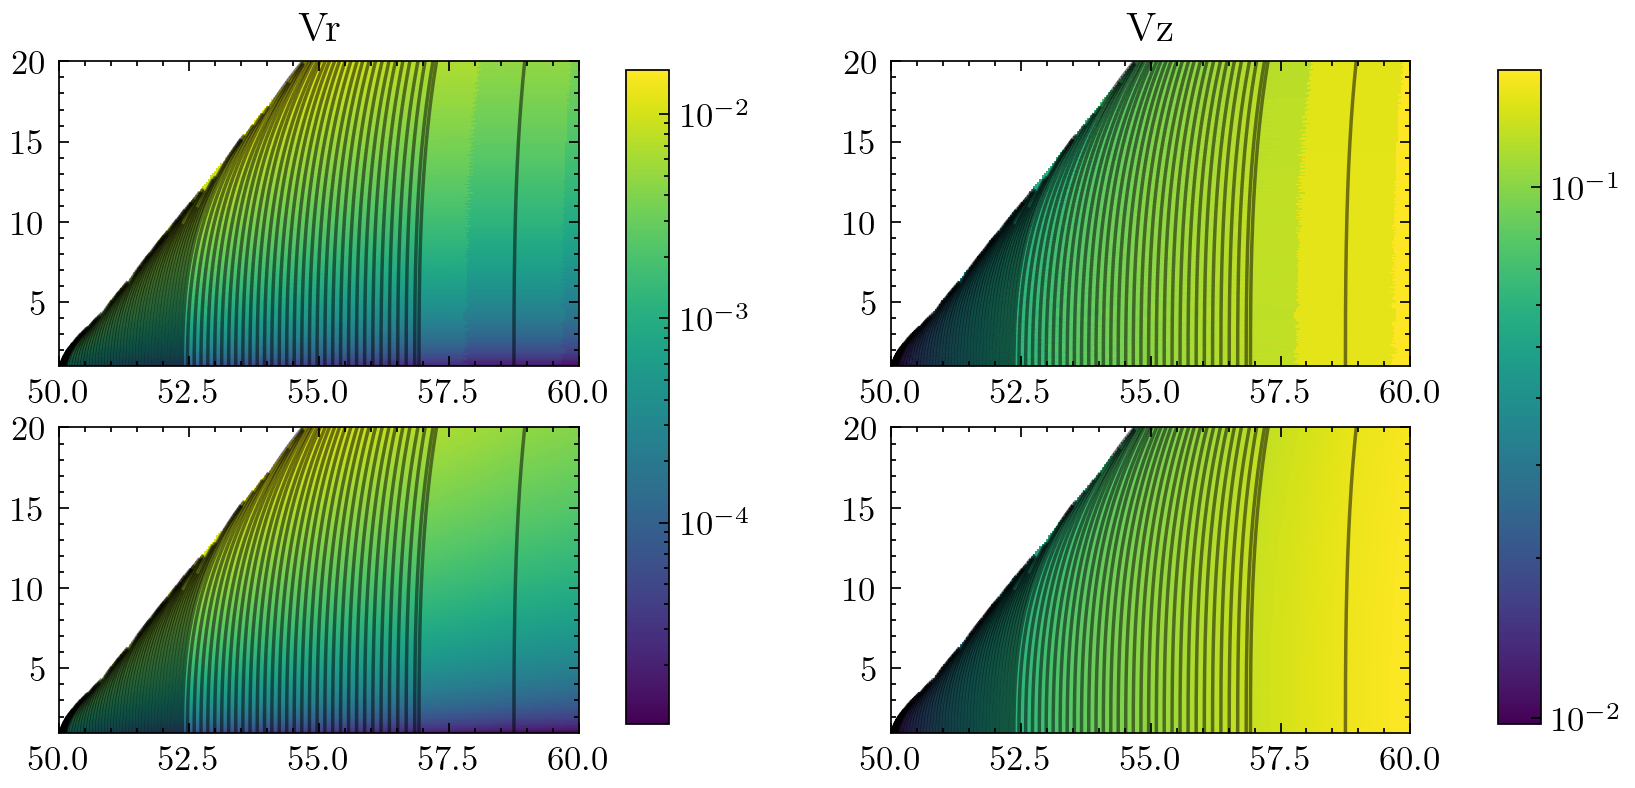

In [98]:
fig, ax = plt.subplots(2, 2, figsize=(2*mnras_width, mnras_width))
cm1 = ax[1,1].pcolormesh(velocity_grid_nn.r_range, velocity_grid_nn.z_range, velocity_grid_nn.vr_grid', norm=LogNorm(), shading="auto")
cm1 = ax[2,1].pcolormesh(velocity_grid_linear.r_range, velocity_grid_linear.z_range, velocity_grid_linear.vr_grid', norm=LogNorm(),shading="auto")
cm2 = ax[1,2].pcolormesh(velocity_grid_nn.r_range, velocity_grid_nn.z_range, velocity_grid_nn.vz_grid', norm=LogNorm(),shading="auto" )
cm2 = ax[2,2].pcolormesh(velocity_grid_linear.r_range, velocity_grid_linear.z_range, velocity_grid_linear.vz_grid', norm=LogNorm(),shading="auto" )

for axis in ax
    for integ_reduced in integrators_interpolated
        axis.plot(integ_reduced.r, integ_reduced.z, color = "black", alpha=0.5)
    end
end

ax[1,1].set_title("Vr")
ax[1,2].set_title("Vz")

cbar_ax = fig.add_axes([0.45, 0.12, 0.025, 0.75])
cbar = fig.colorbar(cm1, cax=cbar_ax)

cbar_ax = fig.add_axes([0.95, 0.12, 0.025, 0.75])
cbar = fig.colorbar(cm2, cax=cbar_ax)


for axis in ax
    axis.set_xlim(50, 60)
    axis.set_ylim(1, 20)
end
plt.subplots_adjust(wspace=0.6)

# Wind Hull

In [10]:
hull1 = iterations_dict[2]["radiative_transfer"].interpolator.wind_hull
hull2 = iterations_dict[3]["radiative_transfer"].interpolator.wind_hull
integ1 = iterations_dict[1]["integrators"]
integ2 = iterations_dict[2]["integrators"];

In [11]:
integrators = iterations_dict[2]["integrators"];
max_times = get_intersection_times(integrators);
r0 = [integ.p.r0 for integ in integrators];
rh, zh, _, _, _ = reduce_integrators(integrators, max_times=max_times);

[ Info: 2021-03-19 09:11:23 Calculating trajectory intersections...


Progress: 100%|█████████████████████████████████████████| Time: 0:00:41


In [12]:
integrators_linear = interpolate_integrators(integrators, n_timesteps=100, max_times=max_times, log=false);
integrators_log = interpolate_integrators(integrators, n_timesteps=20, max_times=max_times, log=true);

rh, zh, _, _, _ = reduce_integrators(integrators_linear)
hull = construct_wind_hull(rh, zh, r0);

[ Info: 2021-03-19 09:13:06 Constructing wind hull...
[ Info: 2021-03-19 09:13:09 Done


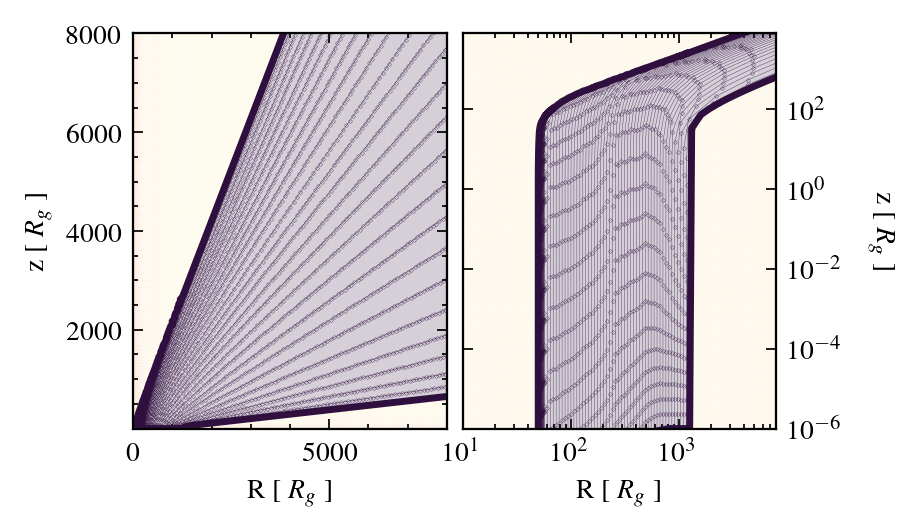

In [45]:
fig, ax = plt.subplots(1, 2, figsize=set_size())

QwindPlotting.plot_wind_hull(hull, fig=fig, ax=ax[1], rmax=8000, zmax=8000, nr=500, nz=500, cmap=cmap_pl, alpha=0.2)
QwindPlotting.plot_streamlines(integrators_linear[1:2:end], fig=fig, linewidth=0.1, ax=ax[1], color = "#" * hex(convert(RGB, get(cmap, 1))), markersize=0.1)

QwindPlotting.plot_wind_hull(hull, fig=fig, ax=ax[2], rmax=8000, zmax=8000, nr=500, nz=500, cmap=cmap_pl, alpha=0.2)
QwindPlotting.plot_streamlines(integrators_log[1:2:end], fig=fig, ax=ax[2], linewidth=0.1, color = "#" * hex(convert(RGB, get(cmap, 1))), markersize=0.1)

vs = reduce(hcat, hull.vertices)

ax[1].plot(vs[1,:], vs[2,:], color = "#" * hex(convert(RGB, get(cmap, 1))))
ax[2].plot(vs[1,:], vs[2,:], color = "#" * hex(convert(RGB, get(cmap, 1))))

ax[1].set_xlim(0,8000)
ax[1].set_ylim(1e-6, 8000)

ax[2].set_xlim(10,8000)
ax[2].set_ylim(1e-6, 8000)
ax[2].set_xscale("log")
ax[2].set_yscale("log")
ax[2].yaxis.tick_right()
ax[2].yaxis.set_ticks_position("both")


ax[1].set_xlabel(L"R [ $R_g$ ]")
ax[2].set_xlabel(L"R [ $R_g$ ]")
ax[1].set_ylabel(L"z [ $R_g$ ]")

ax[2].set_ylabel(L"z [ $R_g$ ]", rotation=-90, labelpad=15)
ax[2].yaxis.set_label_position("right")

#ax[1].set_xticks([0, 2500, 5000, 7500])
#ax[1].set_xticklabels([0, 2500, 5000, 7500])

#ax[2].set_xticks([1e2, 1000])
#ax[2].set_xticklabels([100, 1000])

plt.subplots_adjust(wspace=0.05, hspace=0.0)
fig.savefig("plots/wind_hull.pdf")

# Density Interpolation Grid

In [17]:
integrators = iterations_dict[2]["integrators"];
max_times = get_intersection_times(integrators)
interpolated_integrators = interpolate_integrators(integrators, max_times=max_times)
r, z, vr, vz, n = reduce_integrators(interpolated_integrators)
r0s = [integrator.p.r0 for integrator in integrators]
grid = Qwind.construct_density_grid(r, z, n, r0s, hull2, nr = 500, nz = 500);

[ Info: 2021-03-19 09:16:14 Calculating trajectory intersections...


Progress: 100%|█████████████████████████████████████████| Time: 0:00:38


[ Info: 2021-03-19 09:16:55 Constructing density interpolator...
[ Info: 2021-03-19 09:16:57 Done
[ Info: 2021-03-19 09:16:57 Filling density grid...
[ Info: 2021-03-19 09:17:11 Done


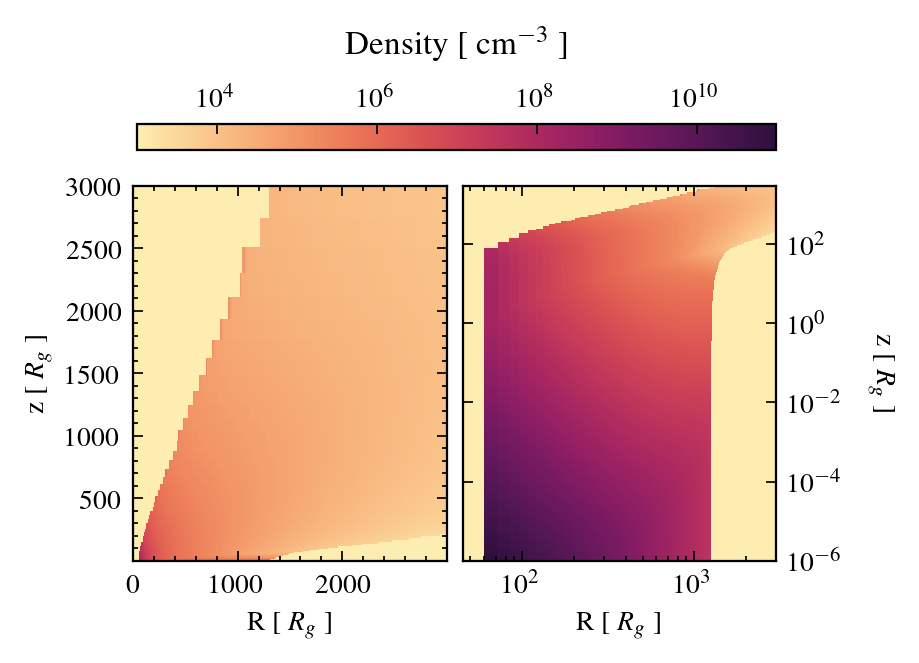

sys:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


In [47]:
fig, ax = plt.subplots(1, 2, figsize=set_size())

rmax = 3e3
zmax = 3e3

_, _, cm = QwindPlotting.plot_density_grid(grid, fig=fig, ax=ax[1], cmap=cmap_pl, vmin=1e3, vmax=1e11, zmax=zmax, rmax=rmax, nr=250, nz=250, colorbar=false)
QwindPlotting.plot_density_grid(grid, fig=fig, ax=ax[2], cmap=cmap_pl, vmin=1e3, vmax=1e11, zmax=zmax, rmax=rmax, nr=250, nz=250, colorbar=false)

ax[1].set_xlabel(L"R [ $R_g$ ]")
ax[1].set_ylabel(L"z [ $R_g$ ]")
ax[1].set_xlim(0, rmax-1)

ax[2].set_xlabel(L"R [ $R_g$ ]")
ax[2].set_ylabel(L"z [ $R_g$ ]", rotation=-90, labelpad=15)
ax[2].set_yscale("log")
ax[2].set_xscale("log")
ax[2].set_xlim(45, rmax)
ax[2].yaxis.tick_right()
ax[2].yaxis.set_label_position("right")
ax[2].yaxis.set_ticks_position("both")


fig.subplots_adjust(bottom=0.15)
cbar_ax = fig.add_axes([0.13, 0.95, 0.77, 0.05])
cb = fig.colorbar(cm, cax=cbar_ax, orientation="horizontal")
cbar_ax.xaxis.set_ticks_position("top")
cbar_ax.xaxis.set_label_position("top")
cbar_ax.set_title(L"Density [ cm$^{-3}$ ]", pad=10)

plt.subplots_adjust(wspace=0.05)

fig.savefig("plots/density_grid.pdf", dpi = dpi)

# X-Ray Grid

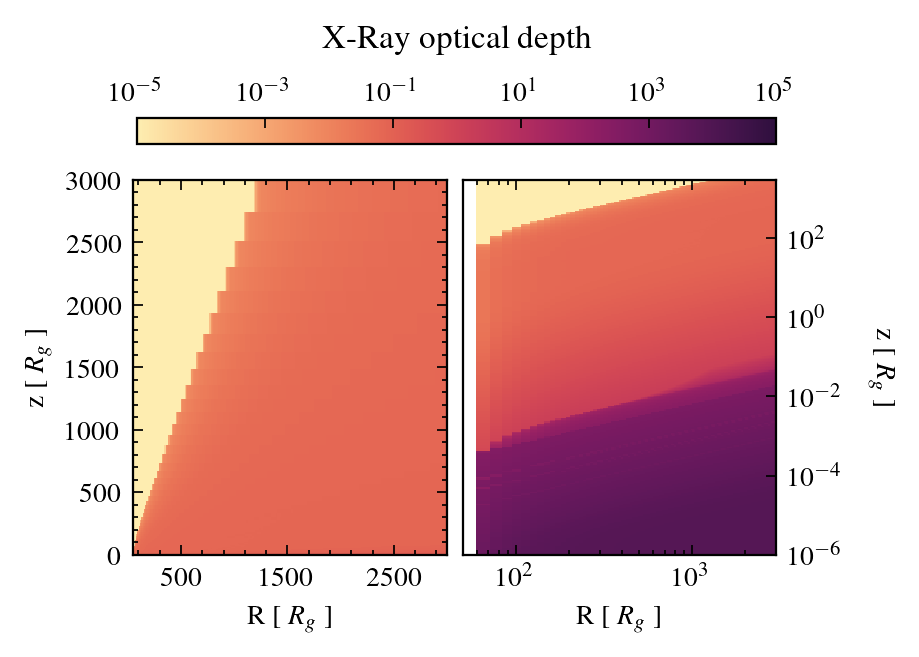

In [48]:
Rg = model.bh.Rg
xl = model.rad.xray_luminosity
density_grid = 
MultipleLocator = matplotlib.ticker.MultipleLocator
ScalarFormatter = matplotlib.ticker.ScalarFormatter 


fig, ax = plt.subplots(1, 2, figsize=set_size())

rmax = 3e3
zmax = 3e3

_, _, cm = QwindPlotting.plot_xray_grid(grid, xl, Rg, fig=fig, ax=ax[1], cmap=cmap_pl, vmin=1e-5, vmax=1e5, nr=250, nz=250, rmax=rmax, zmax=zmax, colorbar=false)
QwindPlotting.plot_xray_grid(grid, xl, Rg, fig=fig, ax=ax[2], cmap=cmap_pl, vmin=1e-5, vmax=1e5, nr=250, nz=250, rmax=rmax, zmax=zmax, colorbar=false)

ax[2].set_xscale("log")
ax[2].set_yscale("log")
ax[2].set_xlabel(L"R [ $R_g$ ]")
ax[2].set_ylabel(L"z [ $R_g$ ]", rotation=-90, labelpad=15)
#ax[2].yaxis.tick_right()
ax[2].yaxis.set_label_position("right")
ax[2].set_xlim(50, rmax)
ax[2].set_ylim(1e-6, zmax)
#ax[2].yaxis.set_tick_params(labelright="on", labelleft="off")
#ax[2].yaxis.set_minor_locator(MultipleLocator(1000))
ax[2].yaxis.tick_right()
#ax[2].yaxis.set_minor_formatter(matplotlib.ticker.ScalarFormatter())

ax[1].set_ylim(0, zmax)
ax[1].set_xlim(50, rmax-1)
ax[1].set_xlabel(L"R [ $R_g$ ]")
ax[1].set_ylabel(L"z [ $R_g$ ]")
ax[1].set_xticks([500, 1500, 2500])

fig.subplots_adjust(bottom=0.15)
cbar_ax = fig.add_axes([0.13, 0.95, 0.77, 0.05])
cb = fig.colorbar(cm, cax=cbar_ax, orientation="horizontal")
cbar_ax.xaxis.set_ticks_position("top")
cbar_ax.xaxis.set_label_position("top")
cbar_ax.set_title("X-Ray optical depth", pad=10)

plt.subplots_adjust(wspace=0.05)
fig.savefig("plots/xray_tau_grid.pdf", dpi=dpi)

# UV Grid

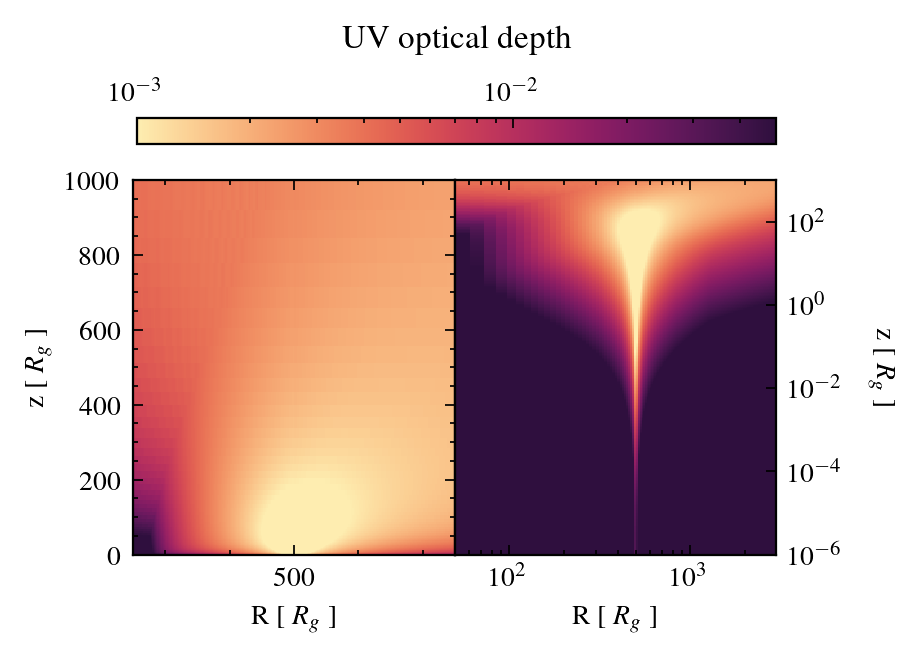

sys:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


In [49]:
Rg = model.bh.Rg

fig, ax = plt.subplots(1, 2, figsize=set_size())

rmin=1
rmax = 1e3
zmax = 1e3

_, _, cm = QwindPlotting.plot_uv_grid(grid, 500.0, Rg, fig=fig, ax=ax[1], cmap=cmap_pl, vmin=1e-3, vmax=5e-2, nr=250, nz=250, rmin=rmin, rmax=rmax, zmax=zmax, colorbar=false)
QwindPlotting.plot_uv_grid(grid, 500.0, Rg, fig=fig, ax=ax[2], cmap=cmap_pl, vmin=1e-3, vmax=5e-2, nr=250, nz=250, rmin=rmin, rmax=3*rmax, zmax=zmax, colorbar=false)

ax[2].set_xscale("log")
ax[2].set_yscale("log")
ax[2].set_xlabel(L"R [ $R_g$ ]")
ax[2].set_ylabel(L"z [ $R_g$ ]", rotation=-90, labelpad=15)
#ax[2].yaxis.tick_right()
ax[2].yaxis.set_label_position("right")
ax[2].set_xlim(50, 3*rmax)
ax[2].set_ylim(1e-6, zmax)
#ax[2].yaxis.set_tick_params(labelright="on", labelleft="off")
#ax[2].yaxis.set_minor_locator(MultipleLocator(1000))
ax[2].yaxis.tick_right()
#ax[2].yaxis.set_minor_formatter(matplotlib.ticker.ScalarFormatter())

ax[1].set_ylim(0, zmax)
ax[1].set_xlim(rmin, rmax)
ax[1].set_xlabel(L"R [ $R_g$ ]")
ax[1].set_ylabel(L"z [ $R_g$ ]")
ax[1].set_xticks([500, 1500, 2500])
ax[1].set_xlim(0, rmax)
ax[1].set_ylim(0, zmax)

fig.subplots_adjust(bottom=0.15)
cbar_ax = fig.add_axes([0.13, 0.95, 0.77, 0.05])
cb = fig.colorbar(cm, cax=cbar_ax, orientation="horizontal")
cbar_ax.xaxis.set_ticks_position("top")
cbar_ax.xaxis.set_label_position("top")
cbar_ax.set_title("UV optical depth", pad=10)

plt.subplots_adjust(wspace=0)
fig.savefig("plots/uv_tau_grid.pdf", dpi=dpi)